In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import random
pd.options.mode.chained_assignment = None

### functions

In [11]:
def make_fset(x, drop=True):
    if len(set(x.split(' '))) < 2:
        print(f"WARNING: Features for '{x}-{x}' (self-self PPI) detected ...")
        if drop == False:
            x1 = x.split(' ')[0]
            fset = frozenset({x1,x1})
            return(fset)
        else:
            return(None)
    else:
        x1 = x.split(' ')[0]
        x2 = x.split(' ')[1]
        fset = frozenset({x1,x2})
        return(fset)
    
def print_nx_stats(cmplx_nx):
    n_test = (cmplx_nx['set'] == 'test').sum()
    n_train = (cmplx_nx['set'] == 'train').sum()
    n_predict = (cmplx_nx['set'] == 'predict').sum()
    min_score = cmplx_nx['ppi_score'].min()
    max_score = cmplx_nx['ppi_score'].max()
    print(f'Test PPIs: {n_test}\tTrain PPIs: {n_train}\tPredicted PPIs: {n_predict}')
    print(f'Range of PPI scores: {min_score} - {max_score}')
    print(f'Rescaled PPI scores for plotting: {cmplx_nx["rescaled_score"].min()} - {cmplx_nx["rescaled_score"].max()}')
    
def rescale(n, range1, range2):
    delta1 = range1[1] - range1[0]
    delta2 = range2[1] - range2[0]
    rs = (delta2 * (n - range1[0]) / delta1) + range2[0]
    return(rs)

def extract_cmplx(all_targets, cmplx):
    cmplx_df = all_targets[all_targets['cmplx']==cmplx]
    cmplx_df.loc[:,'gene_label'] = cmplx_df.loc[:,'gene'].str.replace(' ','\n')
    cmplx_ids = cmplx_df['ID'].to_list()

    # get all complex PPIs & their scores
    cmplx_ppis = [frozenset({i, j}) for i,j in list(combinations(cmplx_ids, 2))]
    cmplx_nx = all_pairs[all_pairs['fs'].isin(cmplx_ppis)].reset_index(drop=True)
    cmplx_nx['rescaled_score'] = [rescale(i, [0,1], [2,6]) for i in cmplx_nx['ppi_score']]
    print(f'Total PPIs measured: {len(cmplx_nx)}/{len(cmplx_ppis)}')
    # get some stats
    print_nx_stats(cmplx_nx)
    return(cmplx_df, cmplx_nx, cmplx_ids)

def map_graph_attr(cmplx_df, cmplx_ids, cmplx_nx):
    # map OGs to gene names [node labels]
    id_map = dict(zip(cmplx_df['ID'], cmplx_df['gene_label']))

    # map OGs to characterization status [node thickness]
    status_map = dict(zip(cmplx_df['ID'], cmplx_df['status'])) # convert to dict

    # map OGs to colors [node colors]
    slc_list = cmplx_df['slc'].to_list()
    print(f"Assigned localizaton(s): {set(slc_list)}")
    id_colors = [slc_nodes[i] for i in slc_list]
    color_map = dict(zip(cmplx_df['ID'], id_colors)) # convert to dict

    # map n phyla to colors [edge color]

    if slc_hues[slc_list[0]]=="cool":
        phyla_colors = phyla_cool
    else:
        phyla_colors = phyla_warm

    # create network & add attributes
    protein_network = nx.Graph()
    # add nodes with color attribute (discrete variable)
    for i in cmplx_ids:
        color = color_map[i]
        gene = id_map[i]
        stroke = node_stroke[status_map[i]]
        protein_network.add_node(gene, color=color, stroke=stroke)

    # add edges with thickness attribute (continuous variable)
    for i in range(len(cmplx_nx)):
        p1 =  list(cmplx_nx['fs'][i])[0]
        p2 =  list(cmplx_nx['fs'][i])[1]
        gene1 = id_map[p1]
        gene2 = id_map[p2]
        linewidth = cmplx_nx['rescaled_score'][i]
        weight = cmplx_nx['ppi_score'][i]
        color = phyla_warm[cmplx_nx['n_phyla'][i]]
        protein_network.add_edge(gene1, gene2, weight=weight, thickness=linewidth, color=color)
    
    return(protein_network)

def plot_cmplx_nx(G_in, cmplx_scores, cmplx_name, layout='spring'):
    
    G = G_in.copy()
    
    # extract node colors and edge thickness attributes
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    node_strokes = [G.nodes[node]['stroke'] for node in G.nodes()]
    edge_thickness = [G.edges[edge]['thickness'] for edge in G.edges()]
    edge_colors = [G.edges[edge]['color'] for edge in G.edges()]    

    # initialize plot
    plt.figure(figsize=(8, 8))

    # add min max info
    min_score = cmplx_scores['ppi_score'].min()
    max_score = cmplx_scores['ppi_score'].max()
    plt.text(x=-1.2, y=1.2, s=f"min: {min_score}; max: {max_score}", fontsize=8, color='black')
    
    
    if len(G) < 10:
        n_size = 5000
        f_size = 12
        #pos = nx.spring_layout(G)
        #pos = nx.kamada_kawai_layout(G)
    else:
        n_size=3000
        f_size = 7.5
        
        #pos = nx.kamada_kawai_layout(G)
        
    if layout=='spring':
        pos = nx.spring_layout(G)
    elif layout=='kk':
        pos = nx.kamada_kawai_layout(G)
    elif layout=='fr':
        pos=nx.fruchterman_reingold_layout(G)
    elif layout=='graph_viz':
        from networkx.drawing.nx_agraph import graphviz_layout
        pos=graphviz_layout(G)
        

    nx.draw_networkx_nodes(
        G, pos,
        node_color=node_colors,  # Use the original node colors
        node_size=n_size,  # Use the original node size
        node_shape="o",  # Node shape (circle)
        linewidths=node_strokes,
        edgecolors="black"
    )

    nx.draw(
        G, pos, 
        with_labels=True, font_size=f_size, alpha=0.9,
        font_color="white", font_weight="bold", 
        edge_color=edge_colors, node_color=node_colors, 
        width=edge_thickness)

    # save figure
    cmplx_out = cmplx_name.replace(' ','_')
    cmplx_out = cmplx_out.replace('/','-') + '_network'
    print(f'Outfile name: ../ppi_ml/highlights/{cmplx_out}_{layout}')
    plt.savefig(f"../ppi_ml/highlights/{cmplx_out}_{layout}.png", dpi=300)
    plt.savefig(f"../ppi_ml/highlights/{cmplx_out}_{layout}.pdf", dpi=300)

    # show the plot
    plt.show()
    G.clear()
    
    return(plt)

### files

In [15]:
ppi_file = '../ppi_ml/results/ppi_predict/scored_interactions_all_LinearSVC_phyla.csv'
annot_file = '../ppi_ml/annotations/leca_eunog_annots_complete.030721.csv'
color_file = '../localization_ml/slc_colors.csv'
cmplx_file = '../ppi_ml/highlights/ppis2highlight_110423.csv'

In [16]:
# all ppi scores
all_pairs = pd.read_csv(ppi_file)
all_pairs = all_pairs[all_pairs['n_phyla'] > 1]
all_pairs['fs'] = [make_fset(i) for i in all_pairs['ID']]

In [17]:
# map status to stroke [node linewidth]
node_stroke = {'Known': 2, 'Novel': 4}

# edge color options
phyla_cool = {1: "#D9D0D9", 2: "#C1DDE8", 3: "#828BBC", 4: "#6B0077"} # purple-blue multi-hue
phyla_warm = {1: "#D9D0D9", 2: "#EBD79C", 3: "#C17F45", 4: "#7D0112"} # red-yellow multi hue scale

# slc map
slc_colors = pd.read_csv(color_file)
slc_nodes = dict(zip(slc_colors['slc'],slc_colors['color']))
slc_hues = dict(zip(slc_colors['slc'],slc_colors['edge_color']))

In [18]:
# ppis to highlight
targets = pd.read_csv(cmplx_file)
cmplx_list = targets['cmplx'].drop_duplicates().to_list()
cmplx_list.remove('Arp2-Arp3 protein complex')
cmplx_list

['Exocyst complex',
 'COG tethering complex',
 'EARP/GARP complex',
 'TRAPP complex',
 'HOPS complex',
 'NRZ complex',
 'EFHC2 complex',
 'Actin-capping complex',
 'C3/C5 convertase complex,',
 'Complement receptor complex',
 'Potential convertase complex']

### testing

In [7]:
# for i in cmplx_list:   
#     print(f'Getting PPI data for {i} ...')
#     # extract one complex
#     cmplx = i
#     cmplx_df, cmplx_nx, cmplx_ids = extract_cmplx(targets, cmplx)
#     ppi_graph = map_graph_attr(cmplx_df, cmplx_ids, cmplx_nx)
#     # remove any isolates
#     ppi_graph.remove_nodes_from(list(nx.isolates(ppi_graph)))
#     print(f"Number of dropped nodes: {len(list(nx.isolates(ppi_graph)))}")
#     nx_plot = plot_cmplx_nx(ppi_graph, cmplx_nx, cmplx, 'spring')
#     plt.clf()
#     nx_plot = plot_cmplx_nx(ppi_graph, cmplx_nx, cmplx, 'kk')
#     plt.clf()
#     nx_plot = plot_cmplx_nx(ppi_graph, cmplx_nx, cmplx, 'fr')
#     plt.clf()

Total PPIs measured: 79/190
Test PPIs: 17	Train PPIs: 0	Predicted PPIs: 62
Range of PPI scores: 0.4762425588373897 - 0.9999999442957718
Rescaled PPI scores for plotting: 3.904970235349559 - 5.999999777183087
Assigned localizaton(s): {'Cell projection'}
Number of dropped nodes: 0
Outfile name: ../ppi_ml/highlights/Arp2-Arp3_protein_complex_network_spring


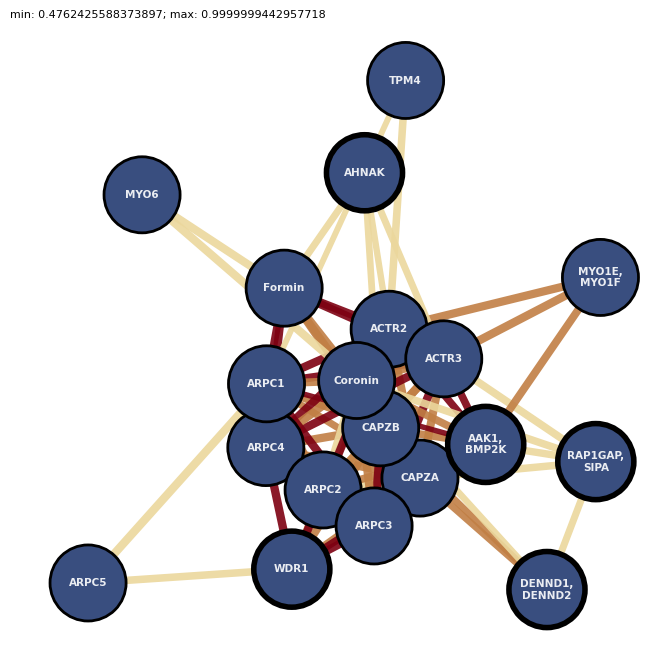

Outfile name: ../ppi_ml/highlights/Arp2-Arp3_protein_complex_network_kk


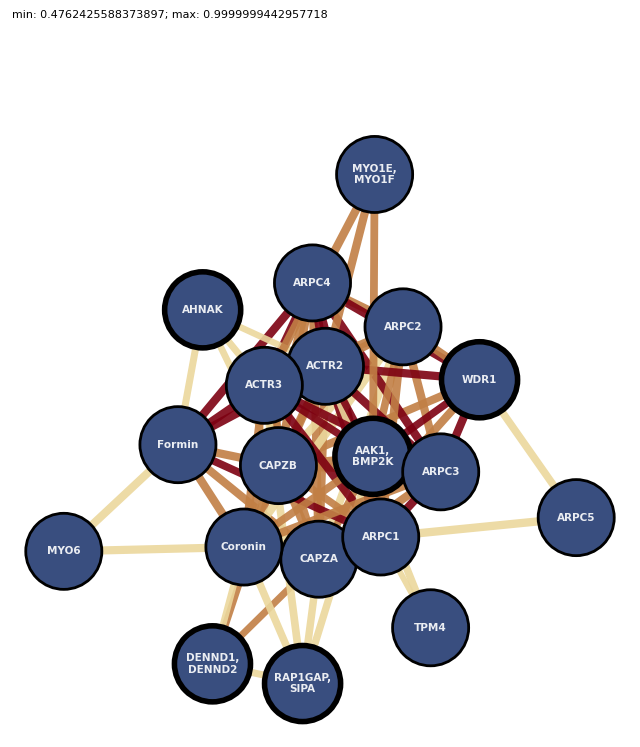

Outfile name: ../ppi_ml/highlights/Arp2-Arp3_protein_complex_network_fr


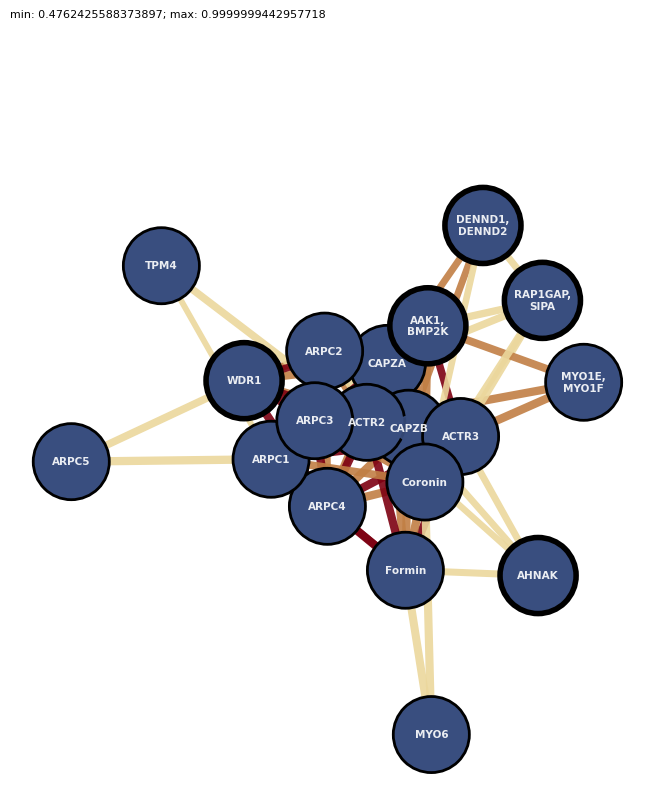

In [19]:
cmplx = 'Arp2-Arp3 protein complex'
cmplx_df, cmplx_nx, cmplx_ids = extract_cmplx(targets, cmplx)
ppi_graph = map_graph_attr(cmplx_df, cmplx_ids, cmplx_nx)
# remove any isolates
ppi_graph.remove_nodes_from(list(nx.isolates(ppi_graph)))
print(f"Number of dropped nodes: {len(list(nx.isolates(ppi_graph)))}")
nx_plot = plot_cmplx_nx(ppi_graph, cmplx_nx, cmplx, 'spring')
#plt.clf()
nx_plot = plot_cmplx_nx(ppi_graph, cmplx_nx, cmplx, 'kk')
#plt.clf()
nx_plot = plot_cmplx_nx(ppi_graph, cmplx_nx, cmplx, 'fr')
#plt.clf()

In [13]:
cmplx_df

,ID,cmplx,status,gene,misc_label,slc,gene_label
0,KOG0836,Arp2-Arp3 protein complex,Known,CAPZA,F-actin capping protein complex,Cell projection,CAPZA
1,KOG3174,Arp2-Arp3 protein complex,Known,CAPZB,F-actin capping protein complex,Cell projection,CAPZB
2,KOG1876,Arp2-Arp3 protein complex,Known,ARPC4,Arp2 complex,Cell projection,ARPC4
3,KOG1922,Arp2-Arp3 protein complex,Known,Formin,Arp2 complex,Cell projection,Formin
4,KOG2826,Arp2-Arp3 protein complex,Known,ARPC2,Arp2 complex,Cell projection,ARPC2
5,KOG0677,Arp2-Arp3 protein complex,Known,ACTR2,Arp2 complex,Cell projection,ACTR2
6,KOG0318,Arp2-Arp3 protein complex,Novel,WDR1,Arp2 complex,Cell projection,WDR1
7,KOG0035,Arp2-Arp3 protein complex,Novel,α-actinin,Arp2 complex,Cell projection,α-actinin
8,KOG1523,Arp2-Arp3 protein complex,Known,ARPC1,Arp2 complex,Cell projection,ARPC1
9,KOG0678,Arp2-Arp3 protein complex,Known,ACTR3,Arp3 complex,Cell projection,ACTR3
